In [37]:
#IMPORTS

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import (ttest_ind,
                         shapiro,
                         normaltest,
                         boxcox)



import math
from datetime import datetime
import warnings

In [38]:
warnings.filterwarnings('ignore')

# Contexto

* A House Rocket é uma plataforma digital que tem como modelo de negócio, a compra e a venda de imóveis usando tecnologia. O CEO da House Rocket gostaria de maximizar a receita da empresa encontrando boas oportunidades de negócio.

* Sua principal estratégia é comprar boas casas em ótimas localizações com preços baixos e depois revendê-las posteriormente à preços mais altos. Quanto maior a diferença entre a compra e a venda, maior o lucro da empresa e portanto maior sua receita.
Entretanto, as casas possuem muitos atributos que as tornam mais ou menos atrativas aos compradores e vendedores e a localização e o período do ano também podem influenciar os preços.

# Perguntas
1. Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?
2. Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?
3. A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

## Carregamento e preparação dos dados

In [148]:
sns.set_style('darkgrid')

In [149]:
df = pd.read_csv('kc_house_data.csv')

In [150]:
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [151]:
print(f'Registros: {df.shape[0]}  \nColunas: {df.shape[1]}')

Registros: 21613  
Colunas: 21


## Features disponíveis


**id** - Unique ID for each home sold

**date** - Date of the home sale

**price** - Price of each home sold

**bedrooms** - Number of bedrooms

**bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

**sqft_living** - Square footage of the apartments interior living space

**sqft_lot** - Square footage of the land space

**floors** - Number of floors

**waterfront** - A dummy variable for whether the apartment was overlooking the waterfront or not

**view** - An index from 0 to 4 of how good the view of the property was

**condition** - An index from 1 to 5 on the condition of the apartment,

**grade** - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

**sqft_above** - The square footage of the interior housing space that is above ground level

**sqft_basement** - The square footage of the interior housing space that is below ground level

**yr_built** - The year the house was initially built

**yr_renovated** - The year of the house’s last renovation

**zipcode** - What zipcode area the house is in

**lat** - Lattitude

**long** - Longitude

**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors

**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [153]:
#Convertendo alguns tipos de dados:
df.drop('id', axis = 1, inplace = True)
df.date = pd.to_datetime(df.date)
df.waterfront = df.waterfront.astype('bool')
df.condition = df.condition.astype('category')
df.grade = df.grade.astype('category')
df.view = df.view.astype('category')
df.yr_built = pd.to_datetime(df.yr_built, format = '%Y').dt.year
df.zipcode = df.zipcode.astype('object')

df.yr_renovated = df.yr_renovated.replace(0, np.nan)
df.yr_renovated = pd.to_datetime(df.yr_renovated, format = '%Y').dt.year

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21613 non-null  datetime64[ns]
 1   price          21613 non-null  float64       
 2   bedrooms       21613 non-null  int64         
 3   bathrooms      21613 non-null  float64       
 4   sqft_living    21613 non-null  int64         
 5   sqft_lot       21613 non-null  int64         
 6   floors         21613 non-null  float64       
 7   waterfront     21613 non-null  bool          
 8   view           21613 non-null  category      
 9   condition      21613 non-null  category      
 10  grade          21613 non-null  category      
 11  sqft_above     21613 non-null  int64         
 12  sqft_basement  21613 non-null  int64         
 13  yr_built       21613 non-null  int64         
 14  yr_renovated   914 non-null    float64       
 15  zipcode        2161

In [155]:
df.isnull().sum()

date                 0
price                0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront           0
view                 0
condition            0
grade                0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

In [156]:
round(df.describe(),2)

price  bedrooms  bathrooms  sqft_living    sqft_lot    floors  \
count    21613.00  21613.00   21613.00     21613.00    21613.00  21613.00   
mean    540088.14      3.37       2.11      2079.90    15106.97      1.49   
std     367127.20      0.93       0.77       918.44    41420.51      0.54   
min      75000.00      0.00       0.00       290.00      520.00      1.00   
25%     321950.00      3.00       1.75      1427.00     5040.00      1.00   
50%     450000.00      3.00       2.25      1910.00     7618.00      1.50   
75%     645000.00      4.00       2.50      2550.00    10688.00      2.00   
max    7700000.00     33.00       8.00     13540.00  1651359.00      3.50   

       sqft_above  sqft_basement  yr_built  yr_renovated       lat      long  \
count    21613.00       21613.00  21613.00        914.00  21613.00  21613.00   
mean      1788.39         291.51   1971.01       1995.83     47.56   -122.21   
std        828.09         442.58     29.37         15.52      0.14      0.14   
min        290.00           0.00   1900.00       1934.00     47.16   -122.52   
25%       1190.00           0.00   1951.00       1987.00     47.47   -122.33   
50%       1560.00           0.00   1975.00       2000.00     47.57   -122.23   
75%       2210.00         560.00   1997.00       2007.00     47.68   -122.12   
max       9410.00        4820.00   2015.00       2015.00     47.78   -121.32   

       sqft_living15  sqft_lot15  
count       21613.00    21613.00  
mean         1986.55    12768.46  
std           685.39    27304.18  
min           399.00      651.00  
25%          1490.00     5100.00  
50%          1840.00     7620.00  
75%          2360.00    10083.00  
max          6210.00   871200.00

In [157]:
df.describe(include=['object','category','datetime'])

date     view  condition    grade  zipcode
count                 21613  21613.0    21613.0  21613.0  21613.0
unique                  372      5.0        5.0     12.0     70.0
top     2014-06-23 00:00:00      0.0        3.0      7.0  98103.0
freq                    142  19489.0    14031.0   8981.0    602.0
first   2014-05-02 00:00:00      NaN        NaN      NaN      NaN
last    2015-05-27 00:00:00      NaN        NaN      NaN      NaN

<AxesSubplot:title={'center':'Unique values for house features'}>

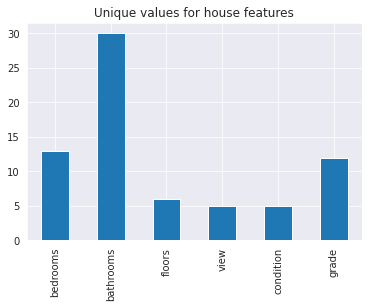

In [177]:
df[['bedrooms','bathrooms','floors','view','condition','grade']].nunique().plot(kind='bar', title = 'Unique values for house features')

# Distribuição das features

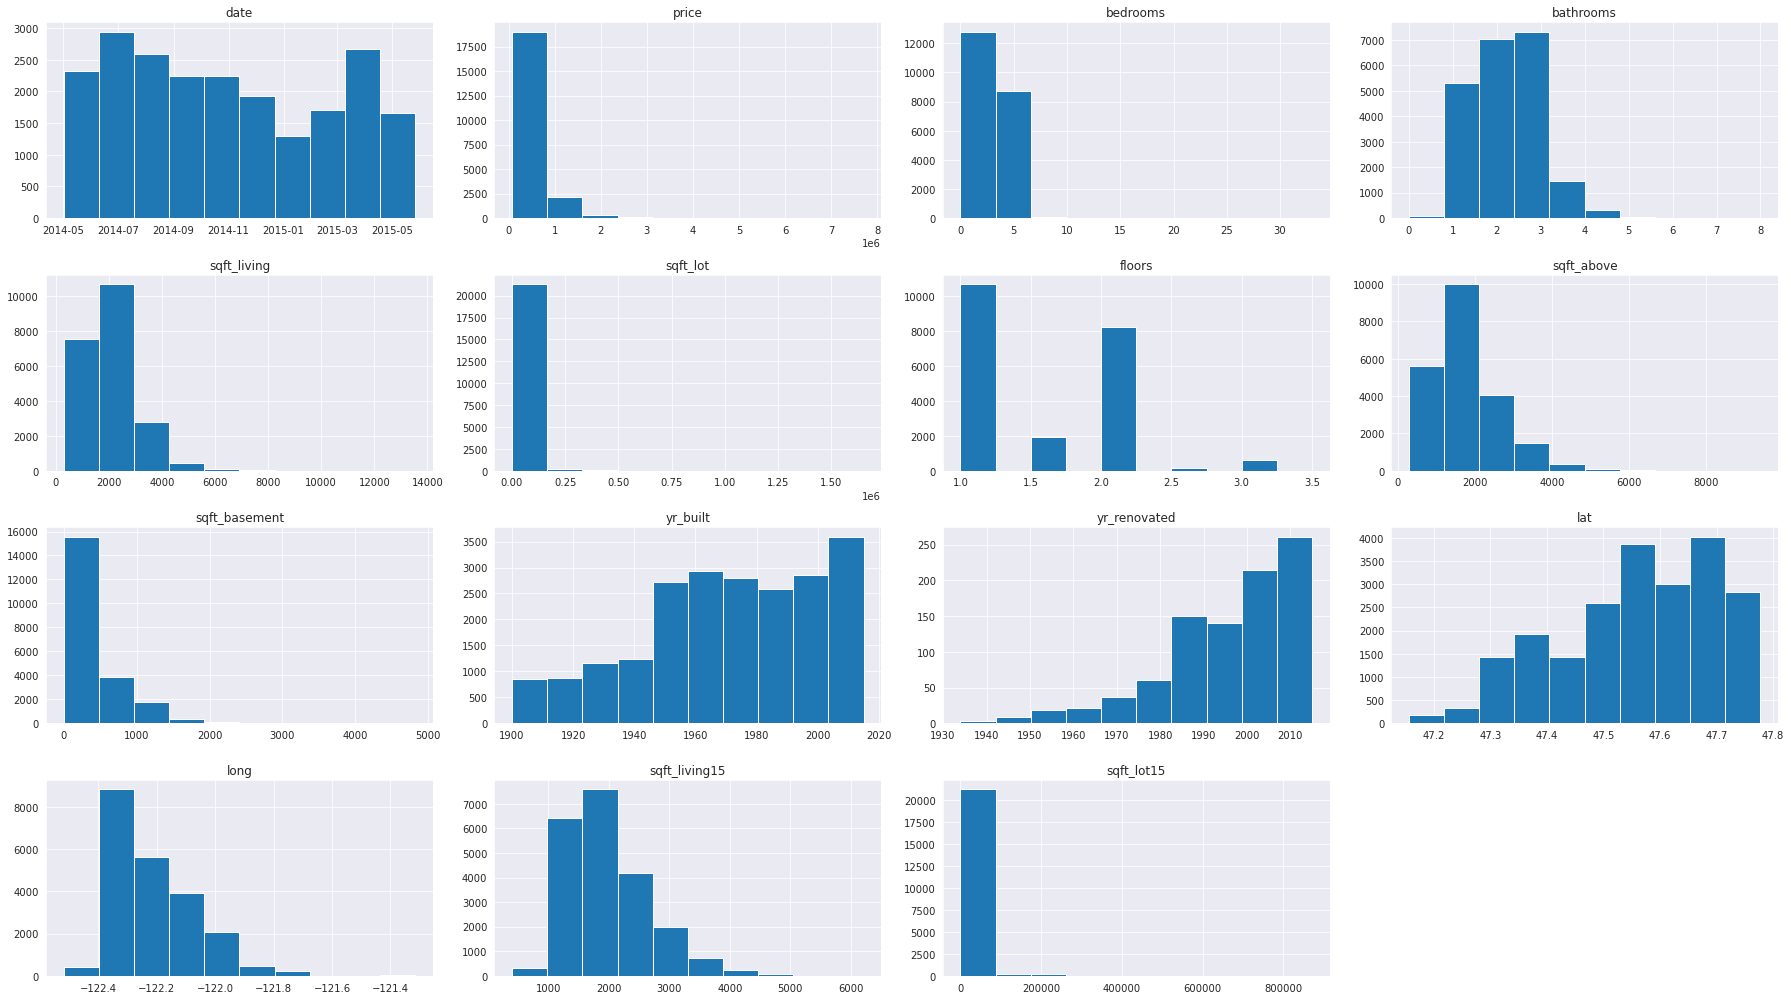

In [158]:
df.hist(figsize = (25,14))
plt.tight_layout()
plt.show()

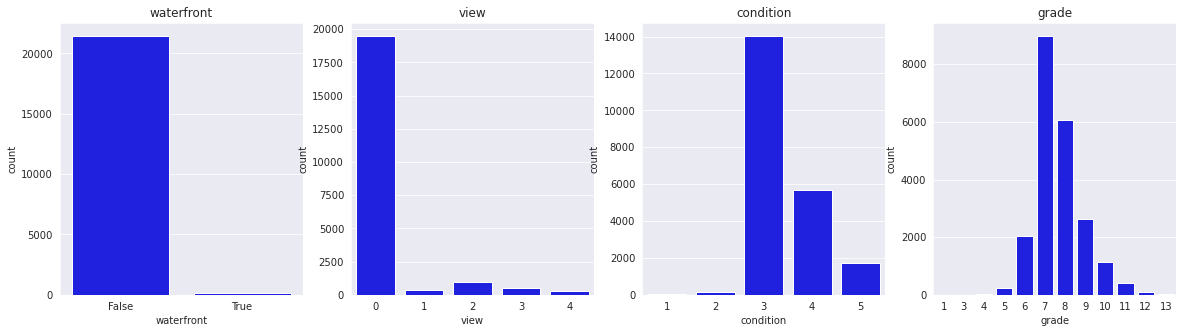

In [160]:
f, ax = plt.subplots(figsize=(20,5), nrows=1, ncols = len(df.select_dtypes(include=['category', 'bool']).columns.values))
c=0
for catcol in df.select_dtypes(include=['category', 'bool']).columns.values:
    sns.countplot(x=catcol, data = df, ax = ax[c], color = 'blue')
    ax[c].set_title(catcol)
    c+=1

## Distribuição de faixas de preço de acordo com a localização

In [8]:
df['price_range'] = pd.qcut(x=df.price, q = 5)

In [299]:
df['price_per_sqft'] = df.apply(lambda x: x.price/x.sqft_living, axis = 1)

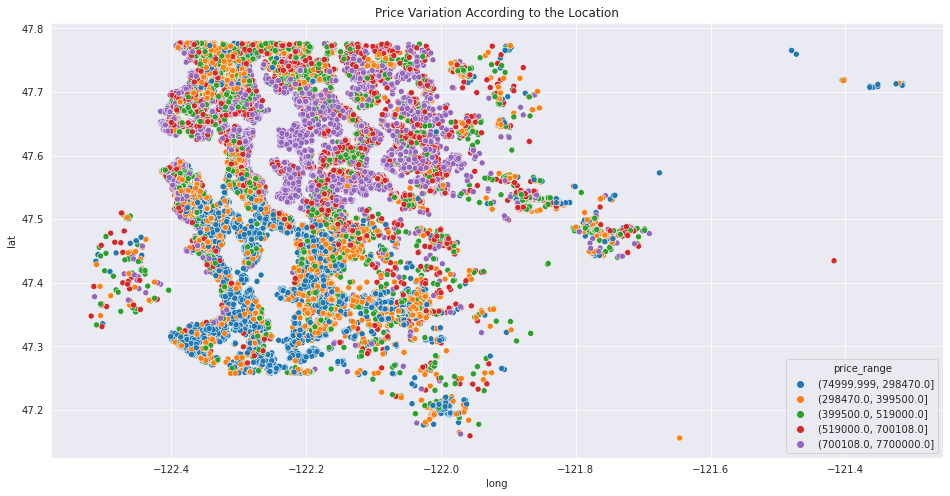

In [304]:
plt.figure(figsize=(16,8))
sns.scatterplot(data = df, y='lat',x='long', hue = 'price_range')
plt.title('Price Variation According to the Location')
plt.show()

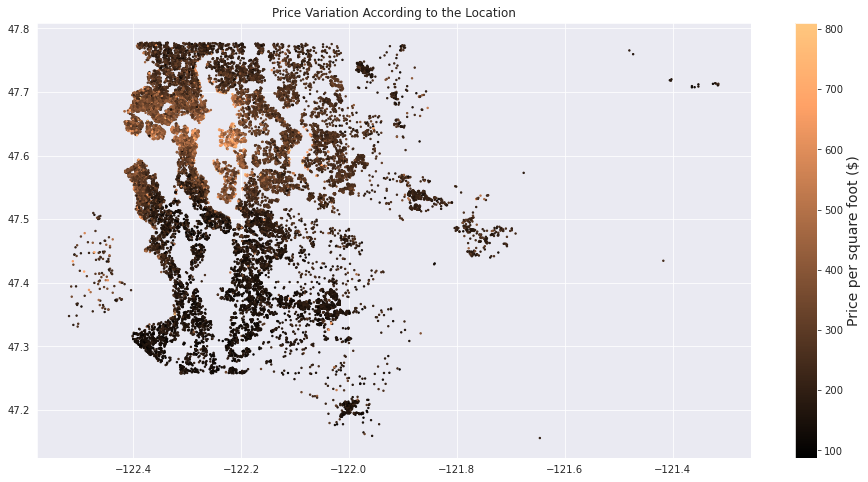

In [387]:
plt.figure(figsize=(16,8))
plt.scatter(x = df.long, y = df.lat, c = df.price_per_sqft, cmap = 'copper', s=2)
plt.colorbar().set_label('Price per square foot ($)', fontsize=14)
plt.title('Price Variation According to the Location')
plt.show()

* A regiao onde se concentra as casas mais valiosas é chamada de Bellevue e Medina, onde residem bilionários das indústrias de tecnologia. Ao redor localizam-se museus de arte, clubes de golf e tenis e outras reservas ambientais
* Parece haver uma região a oeste onde estão concentradas a maior parte das casa com maior faixa de valor. Casas mais a oeste parecem ser mais acessíveis.


## Variação de preços no tempo

In [10]:
#avg_month = df[['date', 'price']].set_index('date').resample('M').mean()

In [11]:
#df.date = pd.to_datetime(df.date, format = '%Y%m%dT%H%M%S')

In [123]:
df['month_no'] = pd.DatetimeIndex(df.date).month
df['month'] = pd.DatetimeIndex(df.date).month_name()

In [124]:
months = df[['month','month_no']].drop_duplicates().sort_values(by='month_no')

In [125]:
months['month'] = months.month.str[:3]

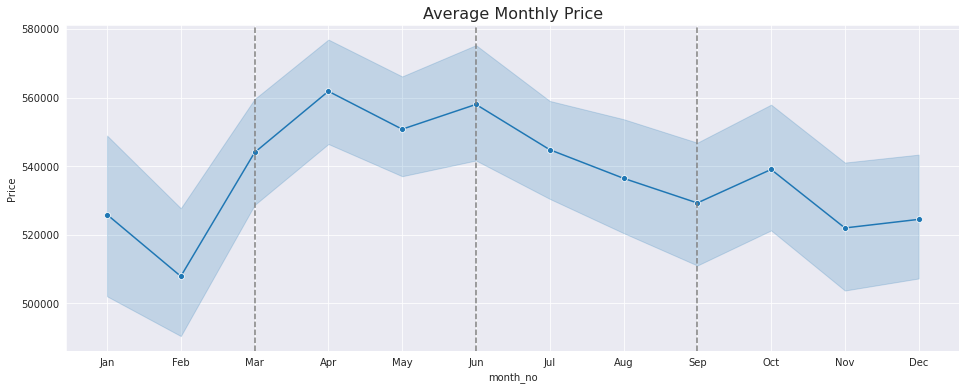

In [126]:
plt.figure(figsize = (16,6))
sns.lineplot(x='month_no', y='price', marker = 'o', data = df )
plt.xticks(ticks = months.month_no, labels = months.month)
plt.ylabel('Price')
plt.title('Average Monthly Price', fontsize = 16)
for v in range(3,12,3):
    plt.axvline(v, color = 'grey', linestyle = '--')

* É possível observar variações nos preços médios das casas durante o ano. 
* De Maio a Fevereiro há uma tendência decrescente nos preços.
* Como o período monitorado é de apenas um ano, não é possível confirmar se há uma sazonalidade que influencia essas variações. Entretanto, se houver, pode-se concluir que o período de fim/início de ano é a melhor época para compra dos imóveis e o período do meio do ano, entre abril e julho, é a melhor época para vendas.
* Entre o o período de menor (feb) e maior (apr) valor médio de compra, há uma variação de 10,63% no preço de venda


Text(0.5, 1.0, 'Price variation related to number of floors, grade, condition and if it is waterfront')

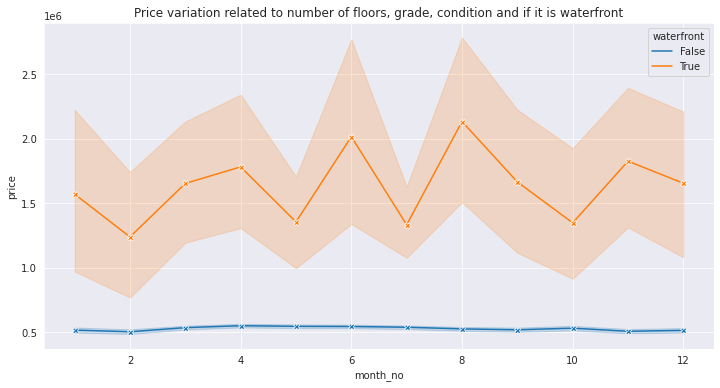

In [127]:
plt.figure(figsize=(12,6))

sns.lineplot(x='month_no', y='price', data = df, hue = 'waterfront', marker = 'X')
plt.title('Price variation related to number of floors, grade, condition and if it is waterfront')

O gráfico mostra que as casas de frente para o mar, em geral, são mais valiosas porém, tem uma variabilidade maior nos preços.

In [131]:
# wseries = df.groupby('waterfront')['price'].mean()

In [170]:
# plt.figure(figsize = (16,4))
# sns.barplot(y=wseries.index, x= wseries.values, orient = 'h')
# plt.title('Average price due to waterfront', fontsize = 16)
# plt.xlabel('Price', fontdict = {'fontsize':12})
# plt.ylabel('Waterfront', fontdict = {'fontsize':12})

# plt.yticks(ticks = [0,1], labels = ['No','Yes'], fontsize=12)
# plt.show()

In [19]:
# df.waterfront.value_counts(normalize = True)

0    0.992458
1    0.007542
Name: waterfront, dtype: float64

No entanto, apenas 0,7% das casas presentes no dataset apresentam essa característica.

# Análise multivariada

### Features numéricas 

Correlação com a target Price

In [171]:
df.corr().iloc[0,:].sort_values(ascending = False)[1:]

sqft_living      0.702035
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.127894
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
long             0.021626
Name: price, dtype: float64

O resultado indica que as variáveis que mais afeta o preço final da casa é sua área de interior(sqft_living), condição de preservação das instalações e estrutura (grade) e área acima do nível do solo. É também importante o tamanho das casas próximas à casa em questão (sqft_living15). 

O resultado indica que o tamanho da área de interior, de forma geral, é um dos grandes influenciadores no preço final de compra/venda.

A feature mais relacionada às mudanças que a empresa pode promover no imóvel é a "condition" que avalia o estado de conservação do imóvel no momento da compra. A variável pode indicar oportunidades de reforma para valorizar o preço de venda.

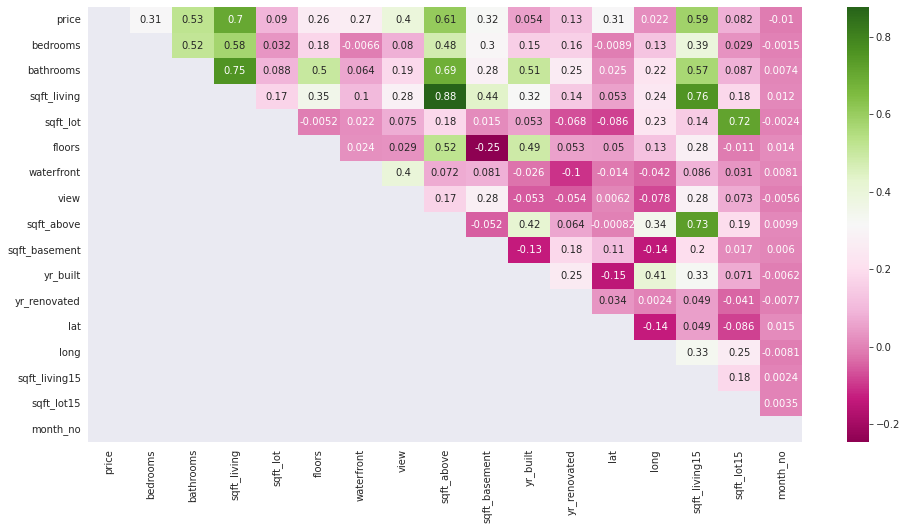

In [133]:
plt.figure(figsize = (16,8))
mask = np.tril(np.ones((df.corr()).shape), 0)
sns.heatmap(df.corr(), annot = True, mask = mask, cmap='PiYG')
plt.show() 

In [167]:
df.select_dtypes(include = ['int','float']).columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

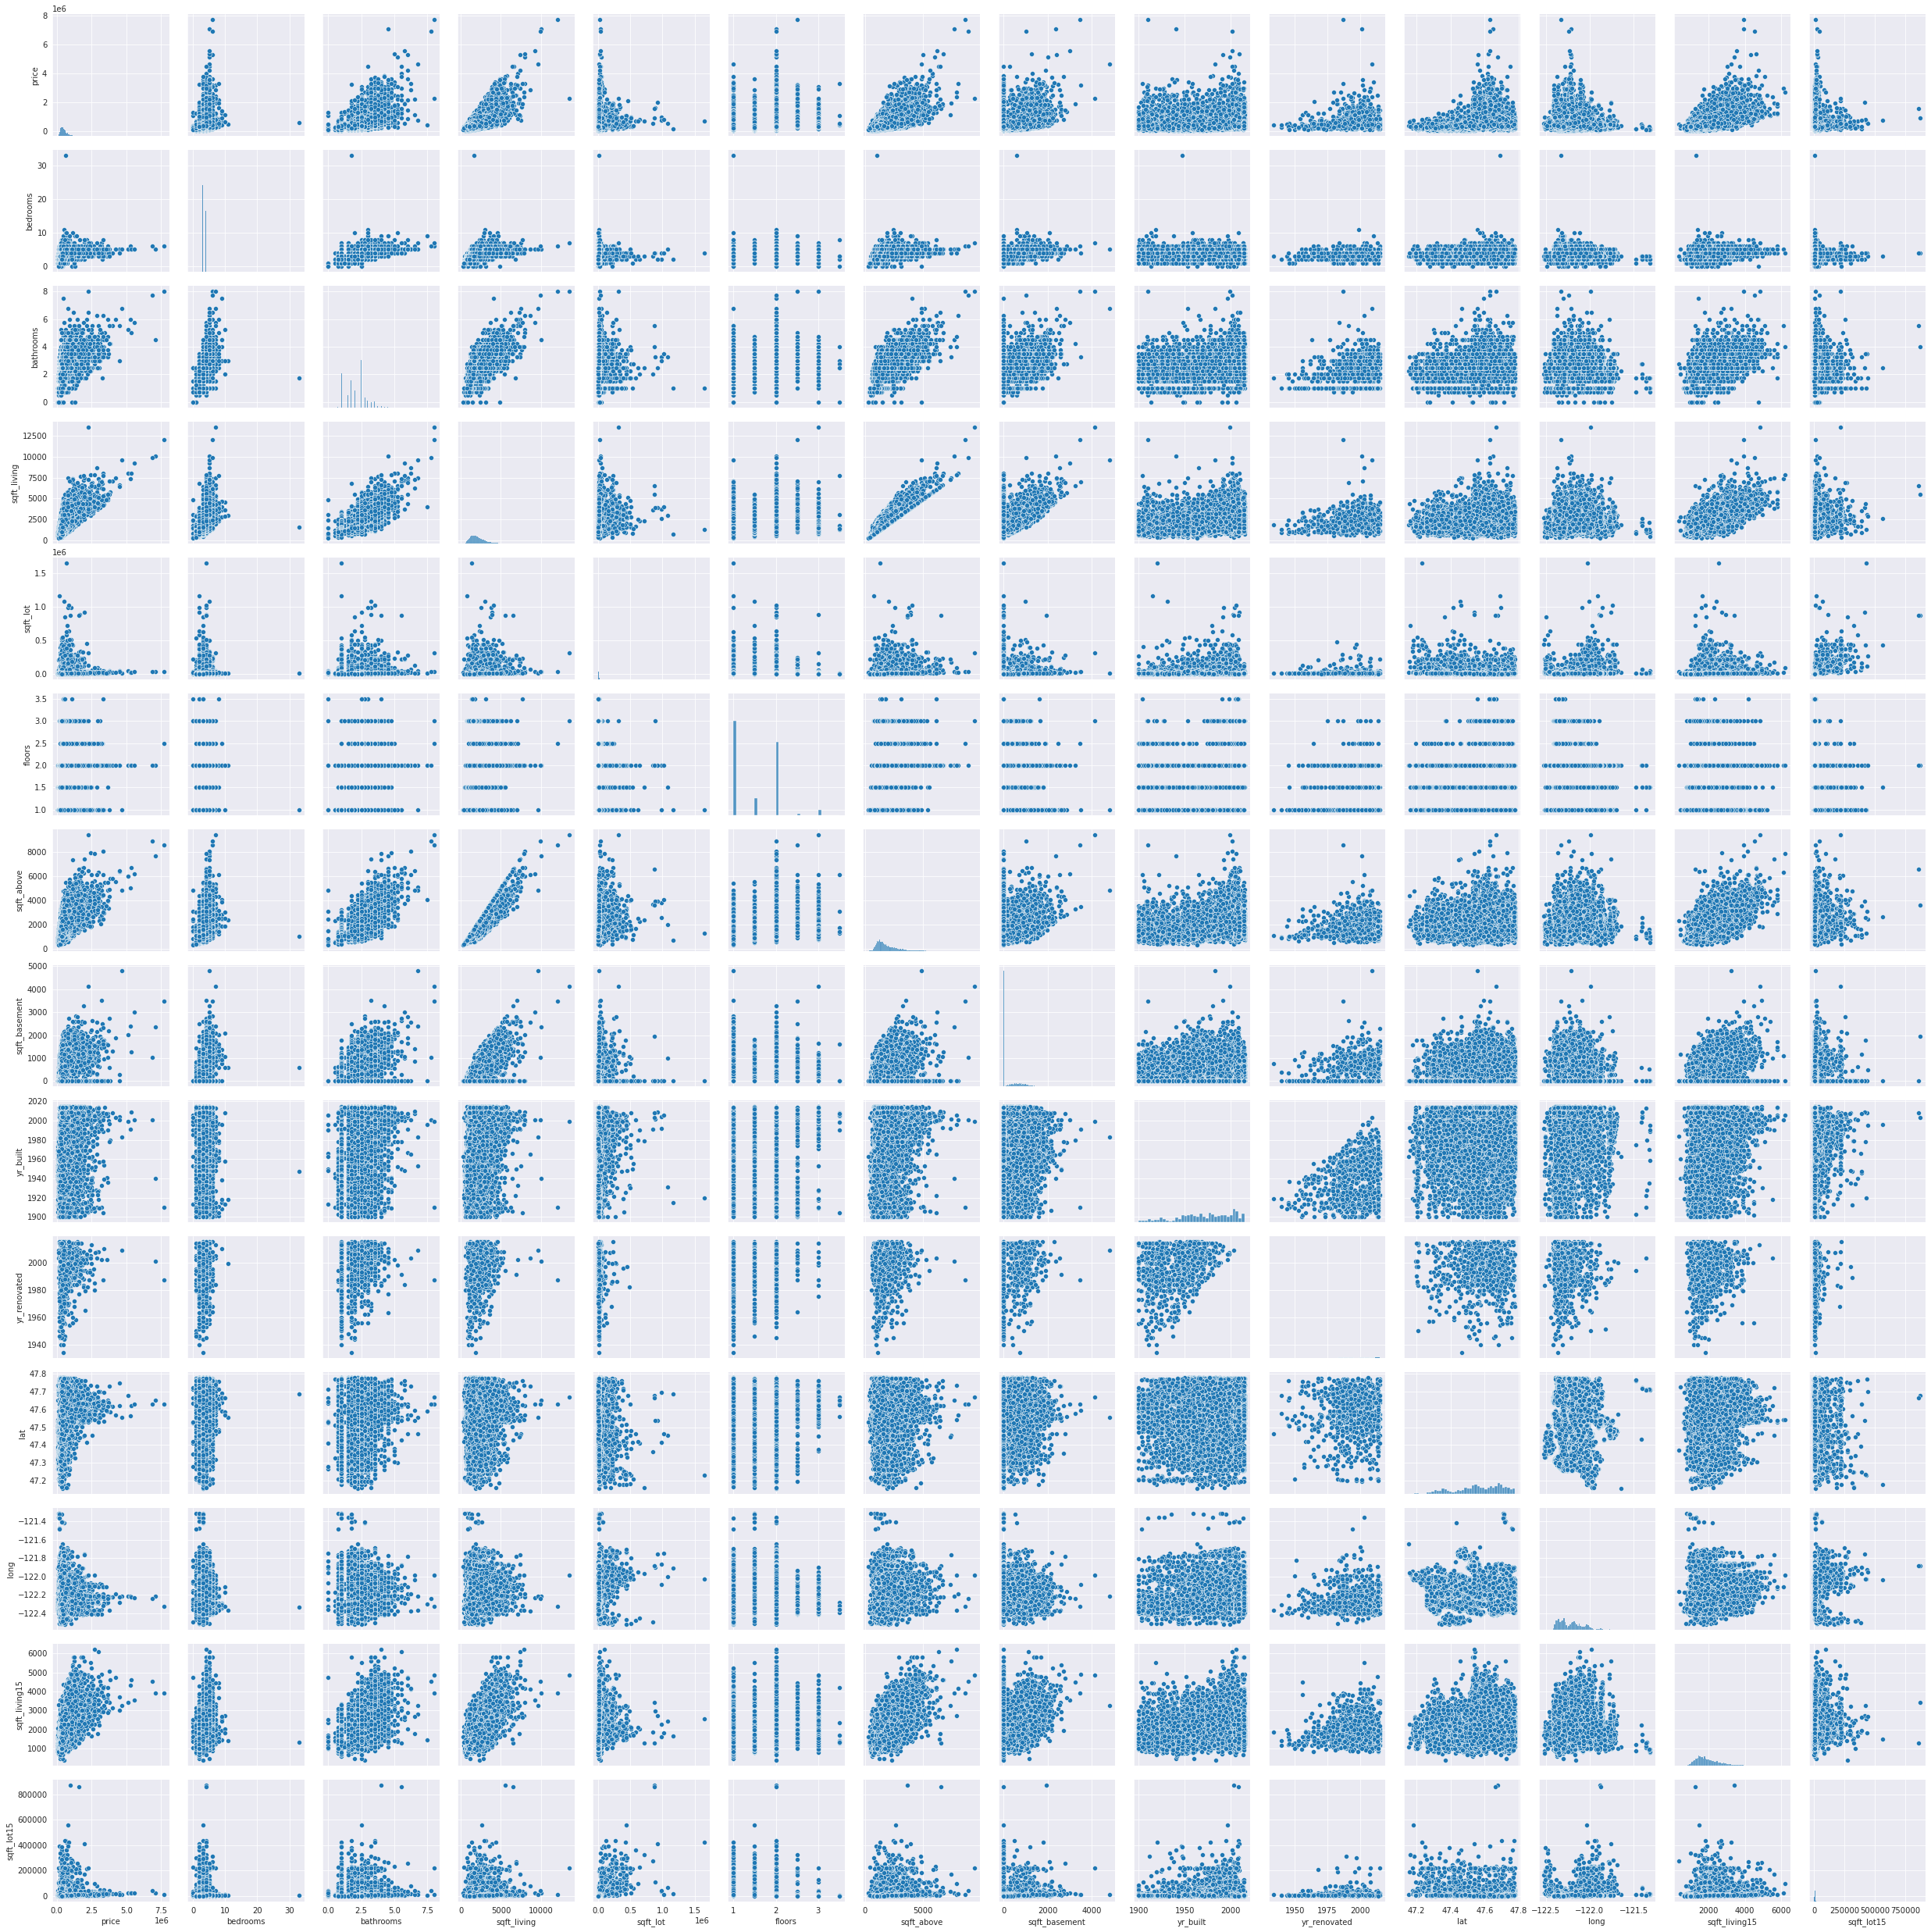

In [ ]:
sns.pairplot(data=df, x_vars = df.select_dtypes(['int','float']).columns.values, y_vars = df.select_dtypes(['int','float']).columns.values)

In [ ]:
sns.countplot(

In [ ]:
df['sqft_livin_base'] = df.sqft_basement/df['sqft_living'] #  % de área de interior abaixo do nivel do solo
df['sqft_livin_above'] = df.sqft_above/df['sqft_living']   #  % de área de interior acima do nivel do solo


In [ ]:
df['sqft_livin_lot'] = df.sqft_living/df['sqft_lot']

Algumas variáveis parecem afetadas pela presença de outliers.

In [28]:
df_numerical = df.drop(['date','waterfront','grade','yr_built','yr_renovated','zipcode','lat','long','price_range', 'view'], axis = 1)

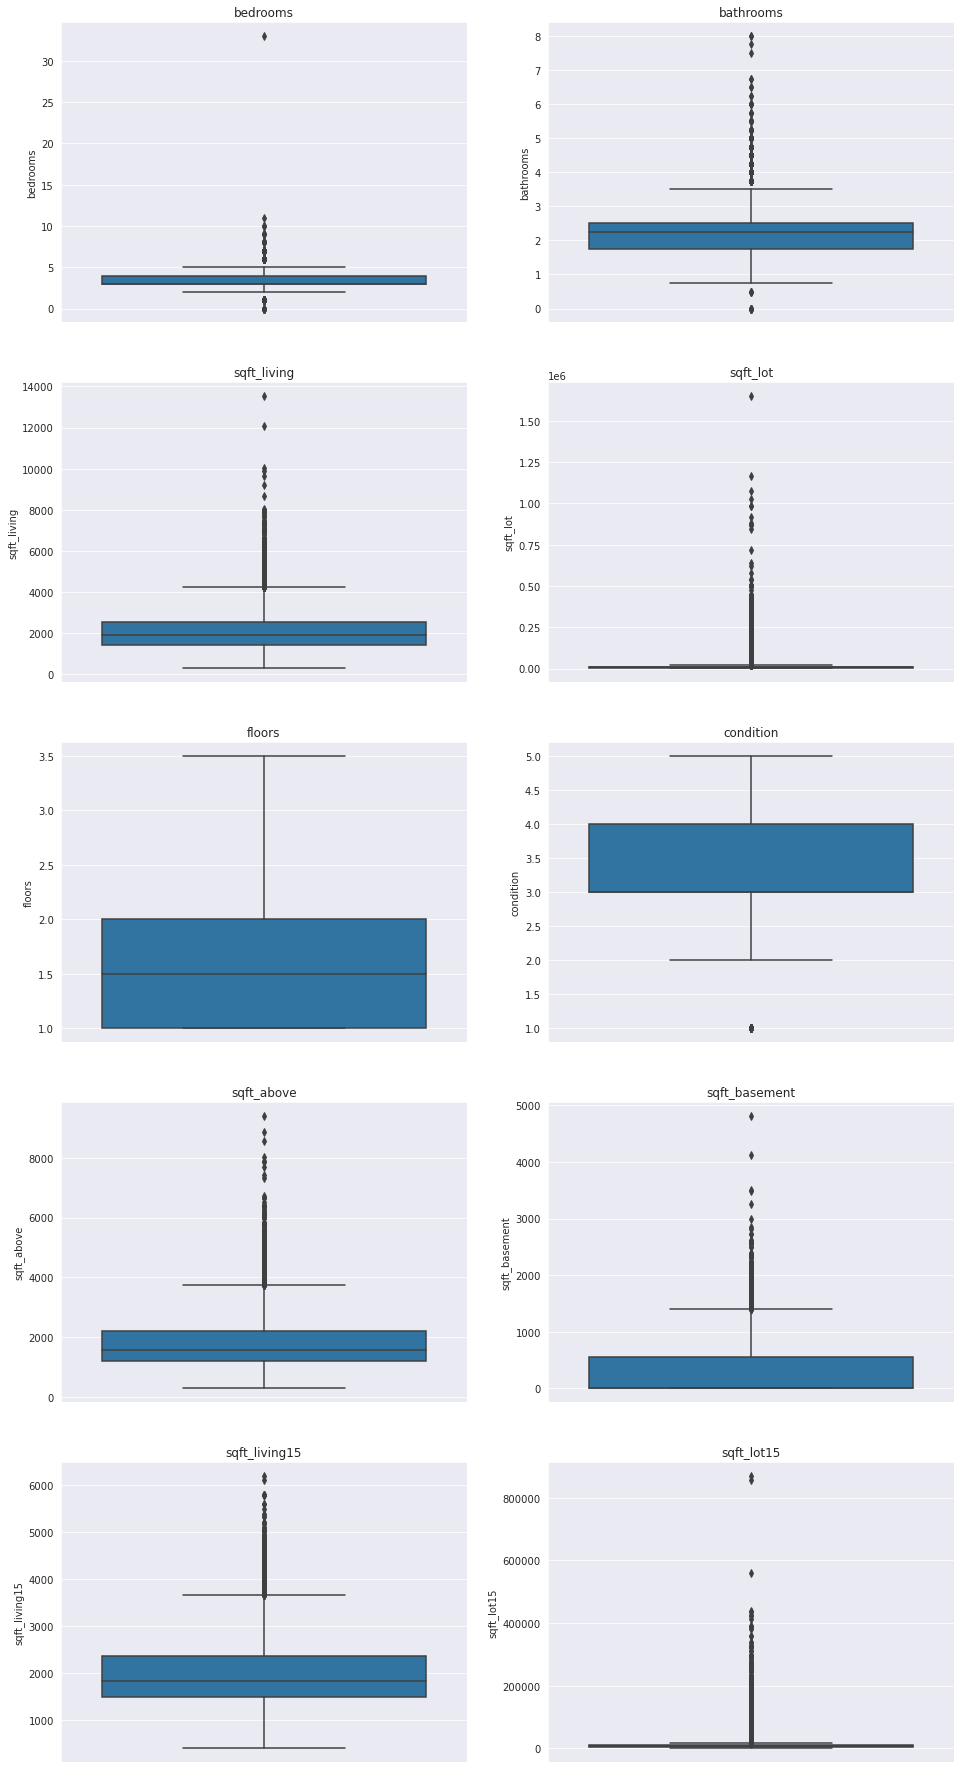

In [30]:
f, ax = plt.subplots(nrows=5, ncols = 2, figsize = (16,32))
rows=0
for i in range(1, 10, 2):
    
    ax[rows][0].set_title(df_numerical.columns[i])
    sns.boxplot(data = df_numerical, y=df_numerical.columns[i], ax = ax[rows][0])
    
    ax[rows][1].set_title(df_numerical.columns[i+1])
    sns.boxplot(data = df_numerical, y=df_numerical.columns[i+1], ax = ax[rows][1])
    rows+=1

Os boxplots mostram que algumas variáveis tem poucos valores que se distanciam razoavelmente dos demais. 

Vamos tentar refazer as análises com esses outliers removidos pelo critério de observação dos boxplots

In [52]:
df_or = df[(df.bedrooms <15) & (df.sqft_living < 11000) & (df.sqft_lot < 1250000) & (df.sqft_basement < 4000) & (df.sqft_lot15<500000) & (df.sqft_livin_lot<3)]

In [53]:
#Removendo variáveis não são numéricas
pp = df_or.drop(['zipcode', 'lat','long','month','month_no', 'waterfront','view','condition','yr_renovated','yr_built'], axis = 1)

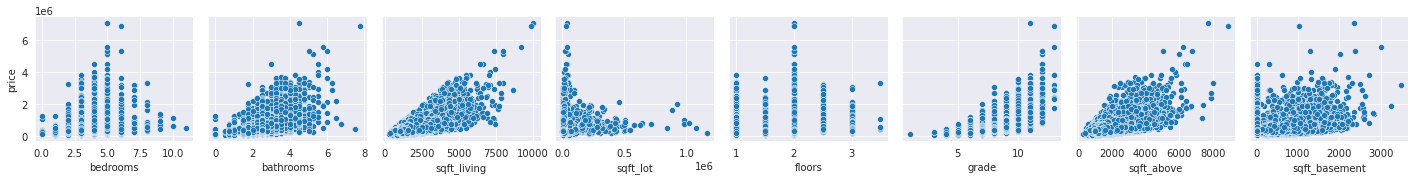

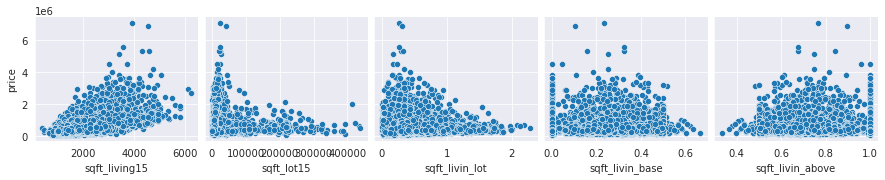

In [54]:
for i in range(2, len(pp.columns), 8):
    sns.pairplot(pp.drop('price_range',axis = 1), y_vars = 'price', x_vars = pp.drop('price_range',axis = 1).columns[i:i+8].values)

# Avaliando a variação no preço médio das casas de acordo com características do imóvel

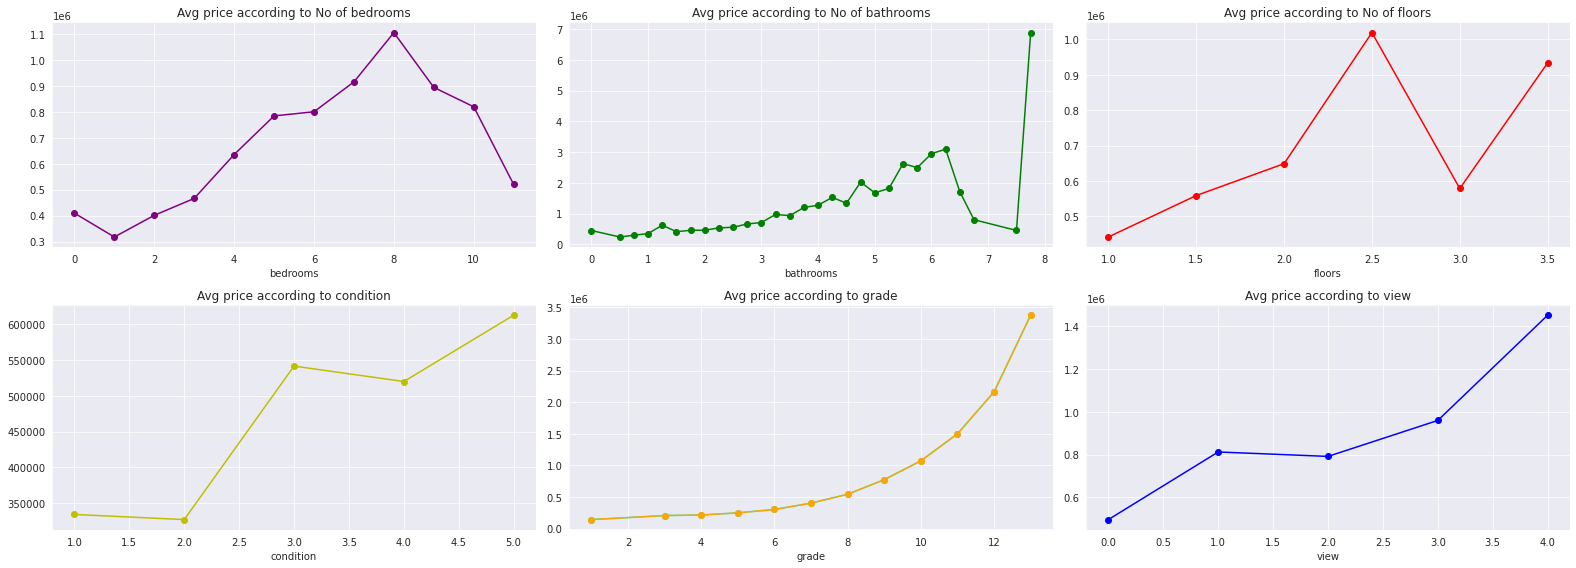

In [398]:
fig, ax = plt.subplots(nrows=2, ncols = 3, figsize=(22,8))

df_or.groupby(by='bedrooms').mean()['price'].plot(marker = 'o', ax = ax[0][0], color = 'purple')
ax[0][0].set_title('Avg price according to No of bedrooms')

df_or.groupby(by='bathrooms').mean()['price'].plot(marker = 'o', ax = ax[0][1], color = 'g')
ax[0][1].set_title('Avg price according to No of bathrooms')

df_or.groupby(by='floors').mean()['price'].plot(marker = 'o', ax = ax[0][2], color = 'r')
ax[0][2].set_title('Avg price according to No of floors')

df_or.groupby(by='condition').mean()['price'].plot(marker = 'o', ax = ax[1][0], color = 'y')
ax[1][0].set_title('Avg price according to condition')

df_or.groupby(by='grade').mean()['price'].plot(marker = 'o', ax = ax[1][1], color = 'cyan')
ax[1][1].set_title('Avg price according to grade')

df_or.groupby(by='grade').mean()['price'].plot(marker = 'o', ax = ax[1][1], color = 'orange')
ax[1][1].set_title('Avg price according to grade')

df_or.groupby(by='view').mean()['price'].plot(marker = 'o', ax = ax[1][2], color = 'blue')
ax[1][2].set_title('Avg price according to view')

plt.tight_layout()

A partir dos gráficos, é possível deduzir que:

* A casa parece valorizar de acordo com a quantidade de quartos até o pico de 8 quartos. Acima desse valor, deve haver uma menor procura dos clientes por este tipo de imóvel, o que pode contribuir para sua desvalorização.
* Parece também haver uma variação positiva, porém mais sutil até aproximadamente 6 banheiros e lavabos.
* A quantidade de pavimentos também parece ter influencia positiva até 2.5.
* O estado de conservação do imóvel parece atingir o ápice de valorização do imóvel no nível 3. Este resultado indica que pode ser uma boa alternativa adquirir casas no estado 2 e investir para eleva-laao estado 3 onde há um grande incremento na valorização do imóvel.
* A nota do design do imóvel parece ter uma relação quadrática com o preço.
* A qualidade da vista parece ter uma relação positiva com a valorização do imóvel

### Variação de preço de acordo com o incremento do número de quartos: 

In [128]:
bd = (df_or.groupby(by='bedrooms').mean()['price'] - df_or.groupby(by='bedrooms').mean()['price'].shift())[1:]
bt = (df_or.groupby(by='bathrooms').mean()['price'] - df_or.groupby(by='bathrooms').mean()['price'].shift())[1:]

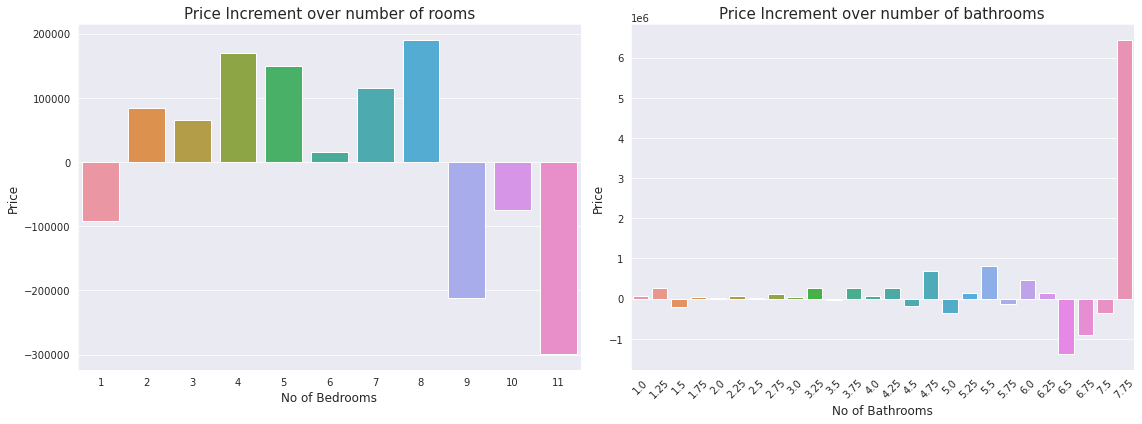

In [419]:
f, ax = plt.subplots(ncols = 2, figsize = (16,6), )

sns.barplot(x = bd.index, y = bd.values, ax = ax[0])
ax[0].set_title('Price Increment over number of rooms', fontsize = 15)

sns.barplot(x = bt.index, y = bt.values, ax = ax[1])
ax[1].set_title('Price Increment over number of bathrooms', fontsize = 15)
ax[1].set_xticklabels(labels = bt.index, rotation = 45)

ax[0].set_xlabel('No of Bedrooms', fontsize = 12)
ax[1].set_xlabel('No of Bathrooms', fontsize = 12)

ax[0].set_ylabel('Price', fontsize = 12)
ax[1].set_ylabel('Price', fontsize = 12)

plt.tight_layout()
plt.show()

Os maiores incrementos médios de preço ṕor número de quarto acontecem nas casas de 4 e 8 quartos.

### Avaliação da variação de preço e área de interior de acordo com a condição do imóvel

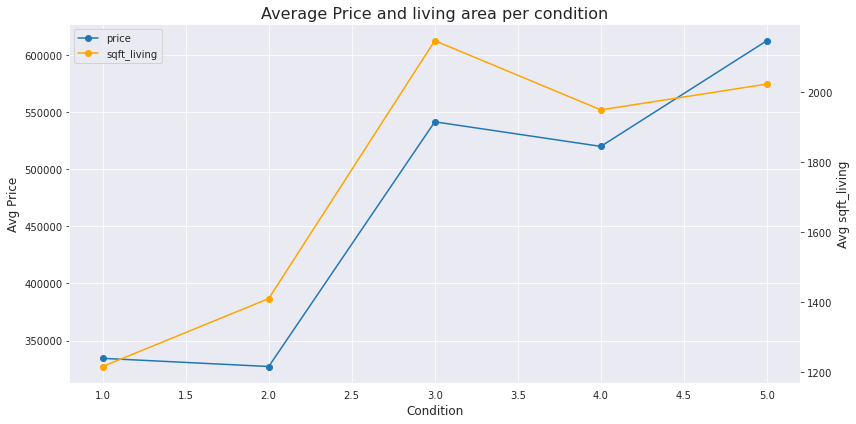

In [58]:
fig, ax =  plt.subplots(figsize=(12,6))

df_or.groupby(by='condition').mean()['price'].plot(marker = 'o', ax=ax, label = 'price')

ax1     =  ax.twinx()

df_or.groupby(by='condition').mean()['sqft_living'].plot(marker = 'o', ax = ax1, color = 'orange', label = 'sqft_living')

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax1.get_legend_handles_labels()

ax.set_ylabel('Avg Price', fontsize = 12)
ax1.set_ylabel('Avg sqft_living', fontsize = 12)
ax.set_xlabel('Condition', fontsize = 12)

ax.legend(handles = (lines_1+lines_2))
ax1.grid(False)

plt.title('Average Price and living area per condition', fontsize = 16)

plt.tight_layout()

* É possível observar através do gráfico que os imóveis em piores condições também são os menores (média de 1400ft²), enquanto que os maiores imóveis (média >2000ft²) encontra-se na condição 3. 
 
* A reforma para o nível 5 parece ser capaz de valorizar ainda mais o imóvel, acima ainda de imóveis com área de interior superior.

In [60]:
round((df_or.groupby(by='condition').mean()['price'][3] - df_or.groupby(by='condition').mean()['price'][2])/df_or.groupby(by='condition').mean()['price'][2]*100,2)

65.42

O resultado indica que há um aumento médio de 65,4% no valor do imóvel ao restaura-lo ao ponto que atinja uma estado de conservação nível 3.

## Avaliação das regiões com concentração de casas nas maiores e menores faixas de preço

<p>Há uma região no mapa que indica uma maior concentração de casa nas menores faixas de preço. Essas casas podem ser boas oportunidades de investimento para emprsa, por isso vamos promover uma análise desse entorno destacado no mapa abaixo.</p>

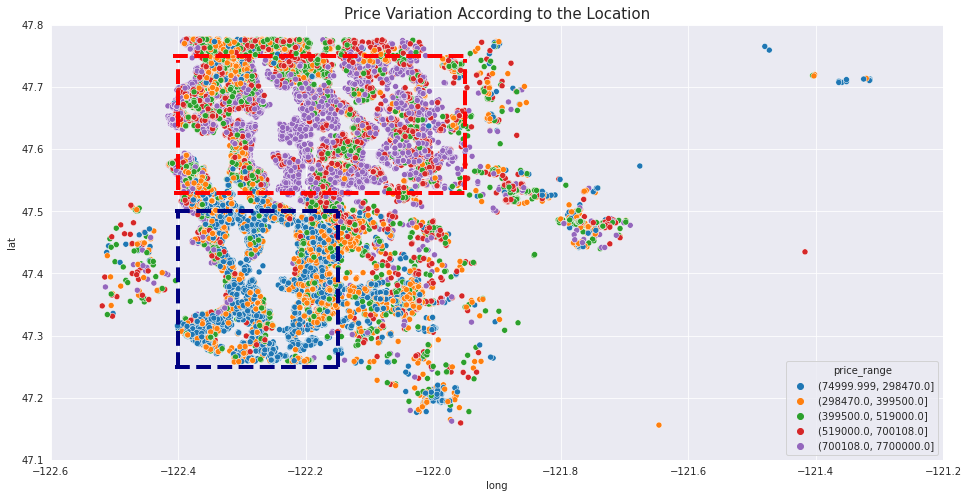

In [397]:
plt.figure(figsize=(16,8))

sns.scatterplot(data = df, y='lat',x='long', hue = 'price_range')
plt.ylim([47.1,47.8])
plt.xlim([-122.6,-121.2])

plt.title('Price Variation According to the Location', fontsize = 15)


plt.axvline(x= -122.4, ymin = 0.214, ymax = 0.572 , linestyle = '--', linewidth = 4, color = 'navy')
plt.axvline(x= -122.15, ymin = 0.214, ymax = 0.572, linestyle = '--', linewidth = 4, color = 'navy')

plt.axhline(y  = 47.25, xmin = 0.1395, xmax = 0.327, linestyle = '--', linewidth = 4, color = 'navy')
plt.axhline(y = 47.5,xmin = 0.1395, xmax = 0.327, linestyle = '--', linewidth = 4, color = 'navy')




plt.axvline(x= -122.4, ymin = 0.62, ymax = 0.92 , linestyle = '--', linewidth = 4, color = 'red')
plt.axvline(x= -121.95, ymin = 0.62, ymax = 0.922, linestyle = '--', linewidth = 4, color = 'red')

plt.axhline(y  = 47.53, xmin = 0.138, xmax = 0.47, linestyle = '--', linewidth = 4, color = 'red')
plt.axhline(y = 47.75,xmin = 0.137, xmax = 0.47, linestyle = '--', linewidth = 4, color = 'red')



plt.show()

O gráfico destaca as regiões onde parecem se concentrar as casas mais valorizadas (vermelho) e menos valorizadas (azul)

In [348]:
low_region = df[(df.lat>=47.25)&(df.lat<=47.5) & (df.long>=-122.4) & (df.long<=-122.15)]

In [349]:
high_region = df[(df.lat>=47.53)&(df.lat<=47.75) & (df.long>=-122.4) & (df.long<=-121.95)]

In [63]:
other_region = df[~((df.lat>=47.25)&(df.lat<=47.5) & (df.long>=-122.4) & (df.long<=-122.15))]

In [ ]:
high_v_low = pd.concat([low_region.mean(), high_region.mean(), df.mean()], axis = 1)
high_v_low.columns = ['low','high','all']

In [389]:
cmap = sns.light_palette("seagreen", as_cmap=True)
b = high_v_low.drop(['lat','long'], axis = 0).style.background_gradient(axis = 1, cmap = cmap)
b

A partir da tabela, é possível observar que:

   * As casas na região low valem cerca de metade do valor em relação as demais casas;
   * As casas na região low tem um terreno (sqft_lot) maior do que as casas que estão na região mais bem avaliada. Apesar disso, tem área média interna significativamente menor que as casas de outras áreas;
   * As casas na região low são as que menos passaram por reformas de renovação, sendo apenas cerca metade do percentual em relação às demais;
   * As casas na região high possuem na vizinhança apartamentos com maior área de interior (sqft_living15);
   * Não parece haver influencia significativa do número de pavimentos (floors), banheiros (bathrooms), quartos (bedrooms), condição (condition), design de construção (grade). Esse fato pode indicar que fatores externos ao imóvel podem exercer ma forte influência, considerando ainda que as casas parecem ter sido compradas em épocas parecidas (month_no). Apesar disso, como já foi mostrado, a melhoria do imóvel nessas features pode levar a um incremento no preço do imóvel. O fato aqui apresentado revela apenas que podem haver outros fatores aqui não descritos que influenciam no preço final do imóvel.

### Avaliando o efeito da renovação dos imóveis

In [172]:
df['last_renov'] = df.apply(lambda x: x.yr_renovated if x.yr_renovated > 0 else x.yr_built, axis = 1)

In [174]:
df['renov'] = df.yr_renovated.apply(lambda x: 1 if x>0 else 0)

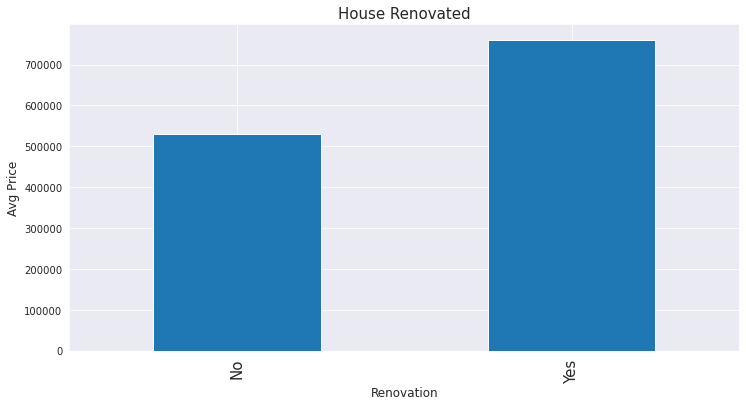

In [421]:
plt.figure(figsize = (12,6))
df.groupby('renov').mean()['price'].plot(kind = 'bar', )
plt.title("House Renovated", fontsize = 15)

plt.ylabel('Avg Price', fontsize = 12)
plt.xlabel('Renovation', fontsize = 12)

plt.xticks(ticks = [0,1], labels = ['No', 'Yes'], fontsize=15)
plt.show()

In [214]:
print(f"Variação de: {round((df.groupby('renov').mean()['price'][1] - df.groupby('renov').mean()['price'][0])/(df.groupby('renov').mean()['price'][0])*100,2)} %")

Variação de: 43.37 %


O gráfico indica que as casas já renovadas são mais valorizadas que casas nunca renovada, com uma média de 43,37% de aumento

In [499]:
df.groupby(['waterfront', 'last_renov'])

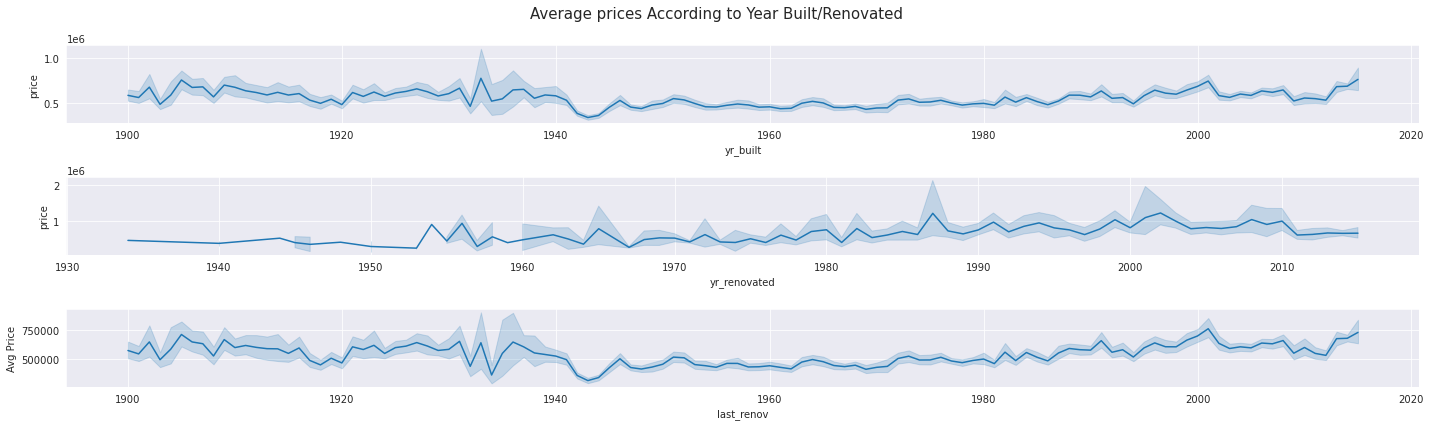

In [515]:
f, ax = plt.subplots(nrows = 3, figsize=(20,6))
sns.lineplot(x='yr_built',y='price', data = df, ax =ax[0])
sns.lineplot(x='last_renov',y='price', data = df, ax =ax[2])
sns.lineplot(x='yr_renovated',y='price', data = df[df.renov==1], ax =ax[1])

#df.groupby('last_renov').mean()['price'].plot()
plt.suptitle('Average prices According to Year Built/Renovated', fontsize = 15)
plt.ylabel('Avg Price')
plt.tight_layout()
plt.show()

Não parece haver uma relação direta entre o último ano da obra e o preço final da casa.

Principais insights da análise: 

* A série temporal indica que há um momento mais propício para comprar (Fev) e vender (Abr) imóvel;
* Há uma oportunidade para valorização do preço de venda do imóvel após adqurido promovendo a restauração e reformas no design de construção do imóvel. Imóveis que passam por reformas em geral, são mais valorizadas;
* O número de quartos e banheiros também pode afetar o preço do imóvel, podendo aumentar o preço do imóvel até certo limiar;
* Comparando as regiões de concentração de casas mais e menos valorizadas, é possível observar que as características dos imóveis são, muitas vezes semelhantes, o que indica que existem características não disponíveis no dataset relativas às residências ou ao seu entorno que valorizam seu preço;
* A expansão das áreas cobertas dos apartamentos construídos pode ajudar na valorização das casas;
